### 1. Environment Setup
This cell prepares the Google Colab environment for PySpark. It performs two key actions:
1.  **Installs Java 17:** Recent versions of Apache Spark require a modern Java Development Kit (JDK). This command installs OpenJDK 17.
2.  **Installs PySpark:** This command installs the Python library for Spark.

We also set the `JAVA_HOME` environment variable, which tells Spark where to find the installed Java runtime.

In [11]:
# Import os to set environment variables
import os

# Install JDK 17
!apt-get update -qq > /dev/null
!apt-get install -y openjdk-17-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

# Install PySpark
!pip install -q pyspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


### 2. Import Libraries
In this step, we import all the necessary Python libraries for the project. These include:
- **`pandas` & `numpy`:** For efficient data loading and manipulation.
- **`matplotlib` & `seaborn`:** for data visualization, such as plotting the confusion matrices.
- **`pyspark` modules:** For creating a Spark session, building the ML pipeline, training classifiers, and evaluating models.

In [12]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark modules
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics


### 3. Start Spark Session
The `SparkSession` is the main entry point for Spark's functionality. We create a new session with a custom application name and configure it to run on the local machine using all available CPU cores (`local[*]`) for maximum performance.

In [13]:
spark = SparkSession.builder \
    .appName("Heart Disease Prediction Notebook") \
    .master("local[*]") \
    .getOrCreate()

print(f"SparkSession started successfully. Spark version: {spark.version}")

SparkSession started successfully. Spark version: 3.5.1


### 4. Data Loading and Pre-processing
This is a critical step where we clean and prepare the data for modeling using the `pandas` library. The workflow includes:
- **Loading:** Reading the `heart_disease_uci.csv` file.
- **Cleaning:** Dropping unnecessary columns (`id`, `dataset`) and removing duplicate rows.
- **Encoding:** Converting categorical string values and booleans into numerical representations.
- **Imputation:** Filling in missing (NaN) values using the median for numerical columns and the mode for categorical ones.
- **Outlier Removal:** Filtering out extreme values from continuous features using the Interquartile Range (IQR) method.
- **Binarization:** Transforming the multi-class target variable (`num`) into a binary target (0: no disease, 1: disease) to simplify the classification task.

In [14]:
# Load the dataset
try:
    df = pd.read_csv("heart_disease_uci.csv")
except FileNotFoundError:
    print("\n!!! ERROR: 'heart_disease_uci.csv' not found.")
    print("Please upload the file to your Colab environment first.")
    spark.stop()
    exit()

# Initial cleaning
initial_rows = len(df)
df = df.drop_duplicates(ignore_index=True)
df = df.drop(columns=['id', 'dataset'])

# Feature Encoding
df['sex'] = df['sex'].replace({'Male': 1, 'Female': 0})
df['fbs'] = df['fbs'].apply(lambda x: 1 if x is True else 0)
df['exang'] = df['exang'].apply(lambda x: 1 if x is True else 0)

cp_map = {'typical angina': 0, 'atypical angina': 1, 'non-anginal': 2, 'asymptomatic': 3}
restecg_map = {'normal': 0, 'st-t abnormality': 1, 'lv hypertrophy': 2}
slope_map = {'upsloping': 0, 'flat': 1, 'downsloping': 2}
thal_map = {'normal': 0, 'fixed defect': 1, 'reversable defect': 2}

df['cp'] = df['cp'].replace(cp_map)
df['restecg'] = df['restecg'].replace(restecg_map)
df['slope'] = df['slope'].replace(slope_map)
df['thal'] = df['thal'].replace(thal_map)

# Impute missing values
median_cols = ['trestbps', 'chol', 'thalch', 'oldpeak']
for col in median_cols:
    df[col].fillna(df[col].median(), inplace=True)
mode_cols = ['fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for col in mode_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Remove outliers from continuous numerical columns
numerical_continuous_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
for feature in numerical_continuous_cols:
    Q1 = df[feature].quantile(0.25); Q3 = df[feature].quantile(0.75); IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR; upper_bound = Q3 + 1.5 * IQR
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
print(f"Rows after full cleaning: {len(df)} (from {initial_rows} initial rows)")

# ** Key Step: Convert to a Binary Classification Problem **
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
print("\nFinal class distribution (0: No Disease, 1: Disease):")
print(df['num'].value_counts())

Rows after full cleaning: 702 (from 920 initial rows)

Final class distribution (0: No Disease, 1: Disease):
num
0    378
1    324
Name: count, dtype: int64


/tmp/ipython-input-14-1256305849.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Male': 1, 'Female': 0})
/tmp/ipython-input-14-1256305849.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cp'] = df['cp'].replace(cp_map)
/tmp/ipython-input-14-1256305849.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_op

### 5. Create Spark DataFrame and ML Pipeline
With the data cleaned, we now transition from `pandas` to `pyspark`.
- **Convert to Spark DataFrame:** The cleaned pandas DataFrame is converted into a Spark DataFrame, which allows for distributed processing.
- **Define ML Pipeline:** We create a `Pipeline` to structure our feature engineering workflow. This pipeline automatically handles the indexing of categorical features and assembles all features into a single vector (`features`) required by Spark's ML models.
- **Split Data:** The prepared dataset is split into a training set (80%) and a testing set (20%). The model will be trained on the training data and evaluated on the unseen testing data.

In [15]:
# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)
spark_df = spark_df.withColumnRenamed("num", "label")

# Define feature columns
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

# Define pipeline stages
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="keep") for col in categorical_cols]
assembler = VectorAssembler(inputCols=numeric_cols + [c + "_indexed" for c in categorical_cols], outputCol="features")

# Create the full pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# Fit the pipeline to the data and transform it
pipeline_model = pipeline.fit(spark_df)
final_df = pipeline_model.transform(spark_df)

# Split the data into training and test sets
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)
print(f"\nTraining data count: {train_data.count()}, Test data count: {test_data.count()}")


Training data count: 577, Test data count: 125


### 6. Train and Evaluate RandomForest Model
We train our first model, a `RandomForestClassifier`. To achieve the best performance, we don't use default parameters. Instead, we use `CrossValidator` to perform hyperparameter tuning. It automatically tests different combinations of `numTrees` (number of trees) and `maxDepth` (tree depth) and selects the best-performing model based on accuracy. The final model is then evaluated on the test set.

In [16]:
# Define the evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(metricName="accuracy")

# Define the model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

# Define the parameter grid for hyperparameter tuning
paramGrid_rf = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

# Set up the CrossValidator
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator_accuracy, numFolds=3, seed=42)

# Train the model
cv_model_rf = cv_rf.fit(train_data)

# Make predictions on the test data
rf_predictions = cv_model_rf.transform(test_data)

# Evaluate the model
rf_accuracy = evaluator_accuracy.evaluate(rf_predictions)
print(f"\nRandomForest Model (Tuned) Accuracy: {rf_accuracy:.3f}")


RandomForest Model (Tuned) Accuracy: 0.848


### 7. Train and Evaluate GBT Model
Next, we train a `GradientBoostedTrees (GBT)` classifier. GBT is another powerful ensemble algorithm known for its high accuracy on tabular data. We train it with a fixed number of iterations (`maxIter=20`) on the training data and then evaluate its performance on the test set.

In [17]:
# Define and train the GBT model
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=20, seed=42)
gbt_model = gbt.fit(train_data)

# Make predictions
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the GBT model
gbt_accuracy = evaluator_accuracy.evaluate(gbt_predictions)
print(f"\nGBT Model Accuracy: {gbt_accuracy:.3f}")


GBT Model Accuracy: 0.816


### 8. Feature Importance Analysis
To better understand what our `RandomForest` model has learned, we analyze its feature importances. This shows which features had the most influence on the model's predictions. High-importance features are the most critical for distinguishing between patients with and without heart disease. This step provides valuable insights into the data and validates that the model is learning medically relevant patterns.

In [18]:
# Extract the best model from the CrossValidator
best_rf_model = cv_model_rf.bestModel

# Get feature importances
feature_importances = best_rf_model.featureImportances

# Match feature names to importance scores
# Note: The order comes from the final assembler stage in the pipeline
final_cols_for_importance = numeric_cols + [c + "_indexed" for c in categorical_cols]
importances_df = pd.DataFrame(
    list(zip(final_cols_for_importance, feature_importances)),
    columns=['feature', 'importance']
).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances in RandomForest Model:")
print(importances_df.head(10))


Top 10 Feature Importances in RandomForest Model:
            feature  importance
6        cp_indexed    0.179201
4           oldpeak    0.129626
0               age    0.122929
9     exang_indexed    0.107154
3            thalch    0.095359
2              chol    0.076863
1          trestbps    0.076385
5       sex_indexed    0.058375
12     thal_indexed    0.045138
8   restecg_indexed    0.031361


### 9. Confusion Matrix Visualization
Accuracy provides a single performance metric, but a confusion matrix offers a more detailed breakdown. It visualizes the performance of each model by showing:
- **True Positives (TP):** Correctly predicted as having disease.
- **True Negatives (TN):** Correctly predicted as not having disease.
- **False Positives (FP):** Incorrectly predicted as having disease.
- **False Negatives (FN):** Incorrectly predicted as not having disease.

This helps us understand what kind of errors our models are making.

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


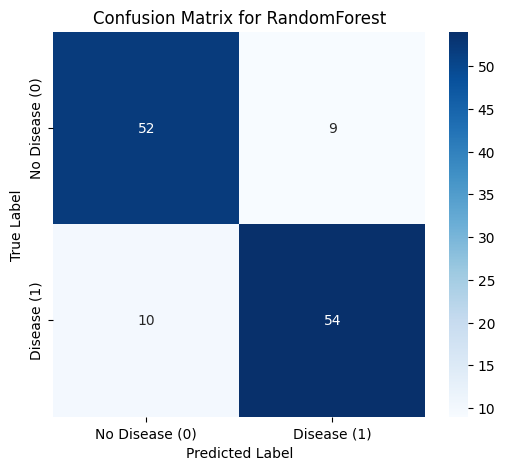

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


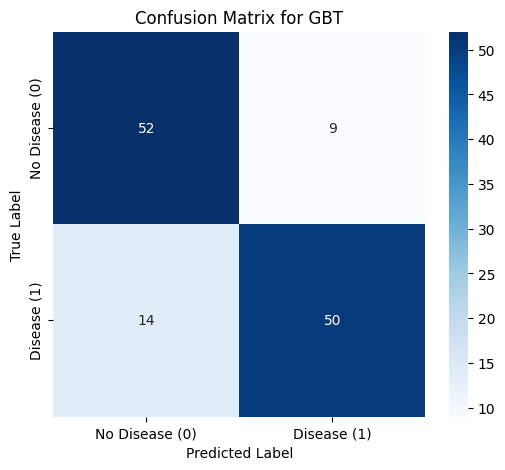

In [19]:
def plot_confusion_matrix(predictions, model_name):
    """A helper function to plot a confusion matrix."""
    preds_and_labels = predictions.select(['prediction', 'label']).rdd.map(
        lambda row: (float(row.prediction), float(row.label))
    )
    metrics = MulticlassMetrics(preds_and_labels)
    confusion_matrix = metrics.confusionMatrix().toArray()

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        confusion_matrix, annot=True, fmt='.0f', cmap='Blues',
        xticklabels=['No Disease (0)', 'Disease (1)'],
        yticklabels=['No Disease (0)', 'Disease (1)']
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot for both models
plot_confusion_matrix(rf_predictions, "RandomForest")
plot_confusion_matrix(gbt_predictions, "GBT")

### 10. Stop Spark Session
Finally, we stop the `SparkSession`. This is a crucial cleanup step that releases all the computational resources (memory and CPU cores) used by Spark, ensuring the notebook environment remains clean.

In [20]:
spark.stop()
print("SparkSession stopped.")

SparkSession stopped.
